# Set directory

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Load data from kaggle

In [2]:
#!/bin/bash
!kaggle datasets download sriramr/fruits-fresh-and-rotten-for-classification


Dataset URL: https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
License(s): unknown
100% 3.58G/3.58G [00:27<00:00, 258MB/s]
100% 3.58G/3.58G [00:27<00:00, 142MB/s]


# Unzip data

In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/fruits-fresh-and-rotten-for-classification.zip')
zip_ref.extractall('/content')
zip_ref.close()
print('Done')

Done


# import Dependences

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import warnings
warnings.filterwarnings('ignore')

import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,VGG19,ResNet50,InceptionV3,Xception,DenseNet121,InceptionResNetV2,ResNet50V2
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input


# Load data using keras loder

In [5]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/dataset/dataset/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256))

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/dataset/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256))

Found 10901 files belonging to 6 classes.
Found 2698 files belonging to 6 classes.


In [21]:
# Clases name
train_ds.class_names

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

In [7]:
# checkig shape
for image,label in train_ds.take(1):
  print(image.shape)
  print(label.shape)

(32, 256, 256, 3)
(32, 6)


# visulize data

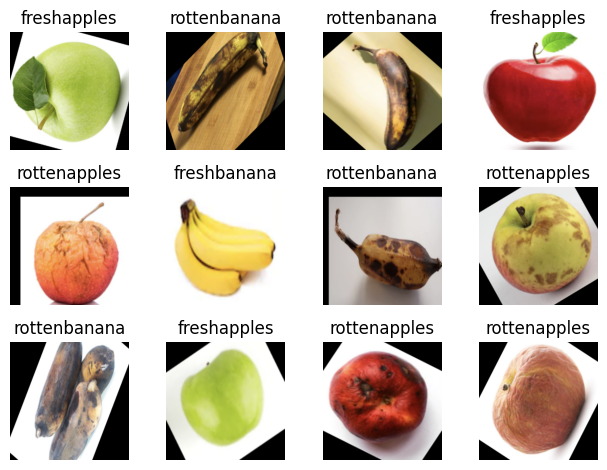

In [8]:
import matplotlib.pyplot as plt
import numpy as np

for image_batch, label_batch in train_ds.take(2):
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))

        # Convert one-hot encoded label to class index
        class_index = np.argmax(label_batch[i].numpy())
        plt.title(train_ds.class_names[class_index])
        plt.axis('off')

plt.tight_layout()
plt.show()



# Data augmentation

In [11]:
train_dataset=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.3,
                                 zoom_range=0.2,
                                 rotation_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True,width_shift_range=0.2,
                             height_shift_range=0.2,
                             brightness_range=[0.5,1.5])

test_dataset=ImageDataGenerator(rescale=1./255)

In [12]:
train_gen=train_dataset.flow_from_directory(
    directory='/content/dataset/dataset/train',
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical'
)
test_gen=test_dataset.flow_from_directory(
    directory='/content/dataset/dataset/test',
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical'
)


Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


# Normalization

In [13]:
import tensorflow as tf
def process(image,label):
  image=tf.cast(image/255. ,tf.float32)
  return image,label

  train_gen=train_gen.map(process)
  test_gen=test_gen.map(process)

# Load VGG16 model

In [14]:
conv_base=VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(256,256,3)
)

In [15]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

# Fine tune VGG16 model

In [16]:
conv_base.trainable = False

In [17]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

# Unfreze top layer of VGG16 for tuning

In [18]:

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name =="block5_conv1":
        set_trainable = True
    layer.trainable = set_trainable


In [19]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

# Build FC layer

In [22]:
model=Sequential()

model.add(conv_base)
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(150,activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(85,activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(6,activation='softmax'))

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │     4,915,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150)            │           600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 85)             │        12,835 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 85)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 85)             │           340 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,646,377 (74.94 MB)

 Trainable params: 12,009,619 (45.81 MB)

 Non-trainable params: 7,636,758 (29.13 MB)

# Set parametors

In [24]:

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Early stoping for prevent overfiting

In [25]:
early_stop = EarlyStopping(
    monitor='val_loss',      # or 'val_accuracy' depending on goal
    patience=5,              # how many epochs to wait after no improvement
    restore_best_weights=True,  # restore weights from the best epoch
    mode='min',              # 'min' for loss, 'max' for accuracy
    verbose=1)

# Train model

In [26]:
history=model.fit(train_gen,epochs=20,validation_data=test_gen,callbacks=early_stop)

Epoch 1/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 302s 817ms/step - accuracy: 0.4166 - loss: 2.1276 - val_accuracy: 0.7861 - val_loss: 0.9469
Epoch 2/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 262s 768ms/step - accuracy: 0.8336 - loss: 0.8708 - val_accuracy: 0.8669 - val_loss: 0.6629
Epoch 3/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 251s 735ms/step - accuracy: 0.8870 - loss: 0.6223 - val_accuracy: 0.9344 - val_loss: 0.4298
Epoch 4/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 253s 743ms/step - accuracy: 0.9133 - loss: 0.5089 - val_accuracy: 0.9381 - val_loss: 0.4009
Epoch 5/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 254s 744ms/step - accuracy: 0.9227 - loss: 0.4482 - val_accuracy: 0.9366 - val_loss: 0.4169
Epoch 6/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 252s 740ms/step - accuracy: 0.9233 - loss: 0.4459 - val_accuracy: 0.9474 - val_loss: 0.3602
Epoch 7/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 252s 738ms/step - accuracy: 0.9331 - loss: 0.4447 - val_accuracy: 0.8921 - val_loss: 0.5742
Epoch 8/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 263s 739ms/step - accuracy: 0.9365 -

# Model accuracy visulize

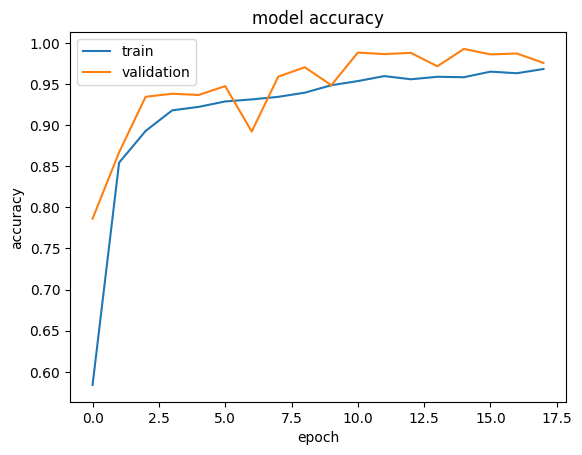

In [27]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# Model loss visulize

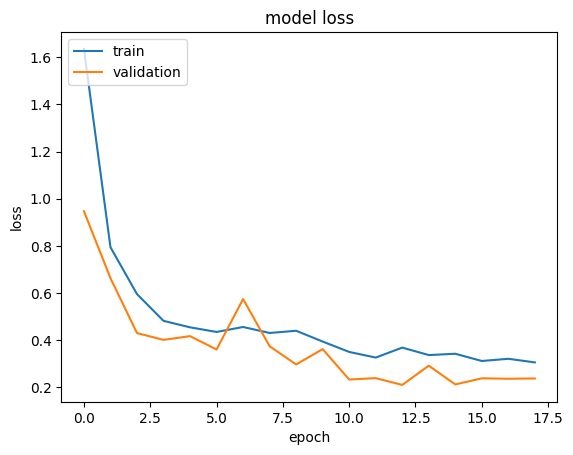

In [28]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [29]:
model.save("fruits_fresh_rotten.keras")
